# <font color=4CBB17>**Preprocesamiento**</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install tensorflow

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow.keras.utils import to_categorical  # convertir etiquetas a one-hot encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
import itertools

In [4]:

base_skin_dir = os.path.join('..', 'input')

# Fusionar imágenes de ambas carpetas HAM10000_images_part1.zip y HAM10000_images_part2.zip en un diccionario

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Se usa un diccionario para poner los nombres completos a cada abreviatura
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
import zipfile
import os

# Ruta al archivo zip en Google Drive
zip_path1 = '/content/drive/MyDrive/cod/LEA3_health_7/data/HAM10000_images_part_1.zip'
zip_path2 = '/content/drive/MyDrive/cod/LEA3_health_7/data/HAM10000_images_part_2.zip'

# Carpeta destino donde se extraerán las imágenes
extract_to = '/content/ham10000_images'

# Crear carpeta si no existe, si ya existe, no lanza error
os.makedirs(extract_to, exist_ok=True)

# Extraer archivos
with zipfile.ZipFile(zip_path1, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

with zipfile.ZipFile(zip_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [6]:
#glob permite buscar archivos que coincidan con un patrón, como *.jpg
from glob import glob

base_skin_dir = extract_to  # ahora apunta a '/content/ham10000_images'

# Diccionario por comprensión que mapea cada nombre de imagen (sin extensión jpg) a su ruta completa en base_skin_dir
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_skin_dir, '*.jpg'))
}

In [7]:
import os

# Ruta al csv en Google Drive
csv_path = '/content/drive/MyDrive/cod/LEA3_health_7/data/HAM10000_metadata.csv'

# Leer el archivo csv
skin_df = pd.read_csv(csv_path)

# Verificar los primeros registros
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
# Se crea una columna con la ruta completa de cada imagen y otra con el nombre completo del tipo de lesión a partir de su abreviación

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)


In [9]:
# Lista ordenada con los nombres únicos de los tipos de lesión en la columna cell_type
categorias = pd.Categorical(skin_df['cell_type']).categories
categorias

Index(['Actinic keratoses', 'Basal cell carcinoma',
       'Benign keratosis-like lesions ', 'Dermatofibroma', 'Melanocytic nevi',
       'Melanoma', 'Vascular lesions'],
      dtype='object')

In [10]:
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes # El número se asigna de acuerdo con el orden en que aparece arriba,
                                                                      # .codes lo que hace es devolver un array de enteros que representa
                                                                      # a cada categoría como un número

### Distribución de clases

<Axes: ylabel='cell_type'>

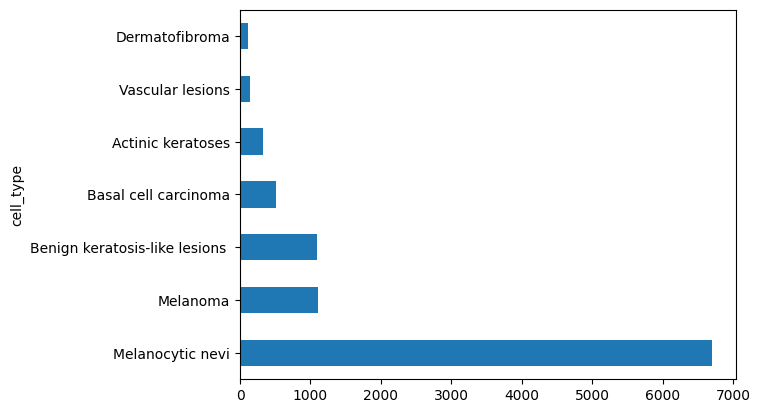

In [11]:
skin_df['cell_type'].value_counts().plot(kind='barh')

usando este conjunto de datos de esta manera, se puede observar un fuerte desbalance en la clases por lo que se recomienda considerar agrupar ciertas lesiones dermatologicas de la siguiente manera; Marca como 1 las clases malignas (Actinic keratoses, Basal cell carcinoma, Melanoma) y 0 las demás: (Melanocytic nevi, Dermatofibroma,Benign keratosis-like lesions,Vascular lesions)

In [12]:
# Se verifican las 3 columnas creadas
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000_images/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [13]:
## cambiamos la etiqueta de 0 a 6 por una binaria teniendo en cuenta si las lesiones son malignas o benignas
malignas = ['Actinic keratoses', 'Basal cell carcinoma', 'Melanoma']
skin_df['cell_type_idx'] = skin_df['cell_type'].apply(lambda x: 1 if x in malignas else 0)


In [14]:
# Se verifican la nueva columna
skin_df.head(10000)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0027419.jpg,Benign keratosis-like lesions,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025030.jpg,Benign keratosis-like lesions,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0026769.jpg,Benign keratosis-like lesions,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025661.jpg,Benign keratosis-like lesions,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000_images/ISIC_0031633.jpg,Benign keratosis-like lesions,0
...,...,...,...,...,...,...,...,...,...,...
9995,HAM_0000193,ISIC_0027950,akiec,histo,60.0,female,face,/content/ham10000_images/ISIC_0027950.jpg,Actinic keratoses,1
9996,HAM_0006180,ISIC_0027615,akiec,histo,70.0,male,upper extremity,/content/ham10000_images/ISIC_0027615.jpg,Actinic keratoses,1
9997,HAM_0006180,ISIC_0028990,akiec,histo,70.0,male,upper extremity,/content/ham10000_images/ISIC_0028990.jpg,Actinic keratoses,1
9998,HAM_0004282,ISIC_0033358,akiec,histo,65.0,female,face,/content/ham10000_images/ISIC_0033358.jpg,Actinic keratoses,1


# Analisis exploratorio

<ipython-input-15-4ec04eed7db4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sex', data=skin_df, palette='Set1')


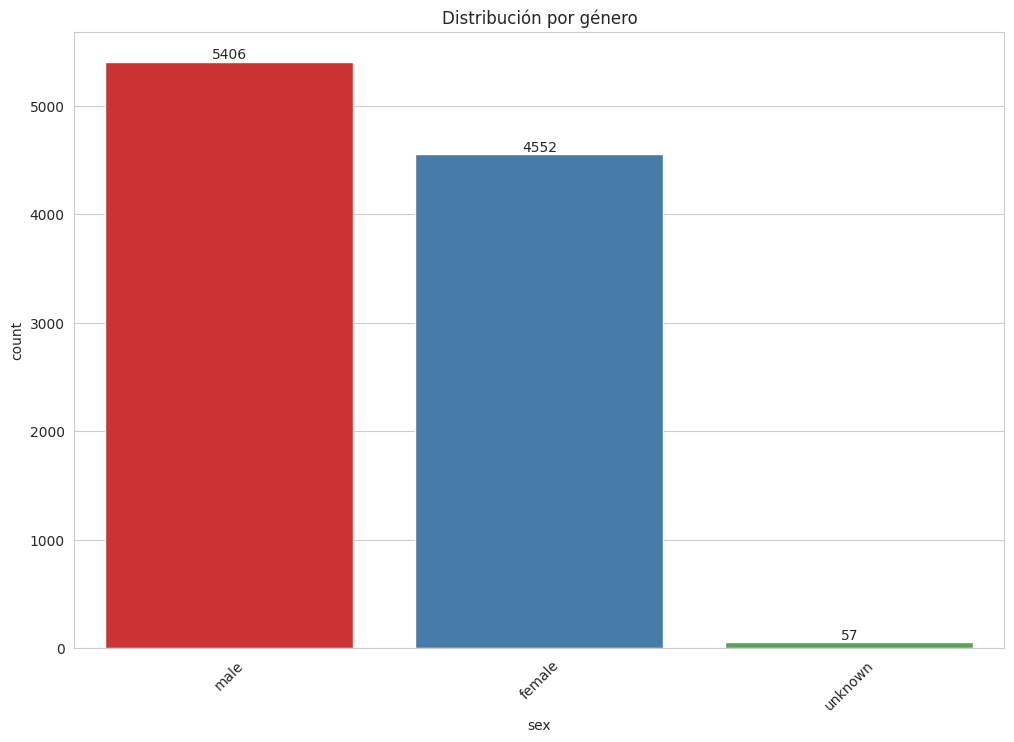

In [15]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(12, 8))

ax = sns.countplot(x='sex', data=skin_df, palette='Set1')
for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribución por género')
plt.xticks(rotation=45)
plt.show()

No hay un patron claro en la cantidad de diagnosticos realizados teniendo en cuenta el sexo.

## Tipo de lesion dermatologica segun el genero

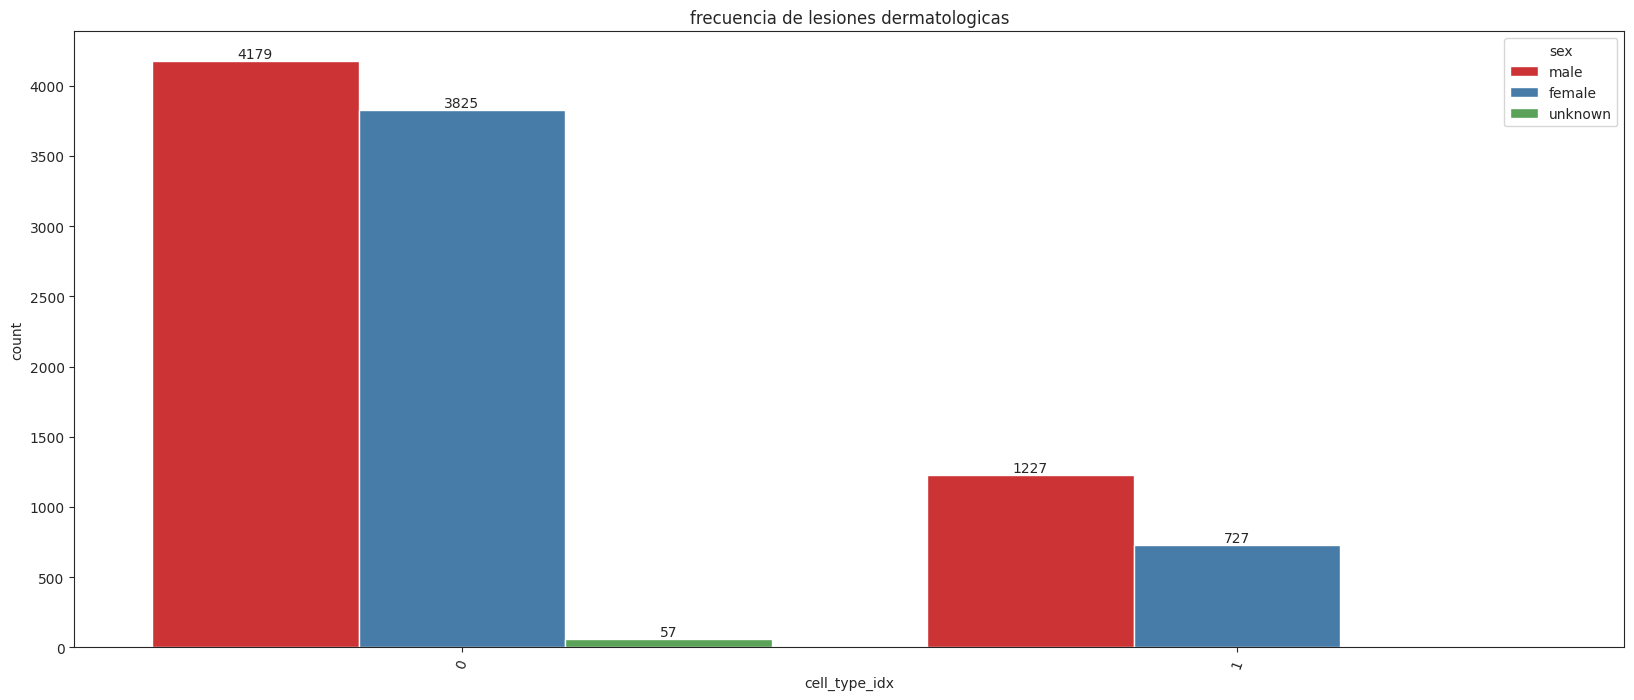

In [16]:
sns.set_style('ticks')
fig,axes = plt.subplots(figsize=(20,8))
ax = sns.countplot(x='cell_type_idx',hue='sex', data=skin_df, order = skin_df['cell_type_idx'].value_counts().index, palette = 'Set1')
for container in ax.containers:
    ax.bar_label(container)
plt.title('frecuencia de lesiones dermatologicas')
plt.xticks(rotation=70)
plt.show()

en el caso del grupo benigno no vemos un diferenciación claro entre hombres y mujeres pero para las lesiones malignas (1954) se encuentra que los hombres participan en un 63% de los casos mientras que las mujeres diagnosticadas con lesiones malignas representan el 37% restante, y recordemos que de 9958 pacientes (catalogados como hombres o mujeres); 5406 son hombres, los cuales equivalen al 54,3%  y 4552 son mujeres equivalente al 45,7% del total señalado

### Ubicación:

<ipython-input-17-effdc64dd434>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='localization',data=skin_df, order = skin_df['localization'].value_counts().index, palette = 'Set1')


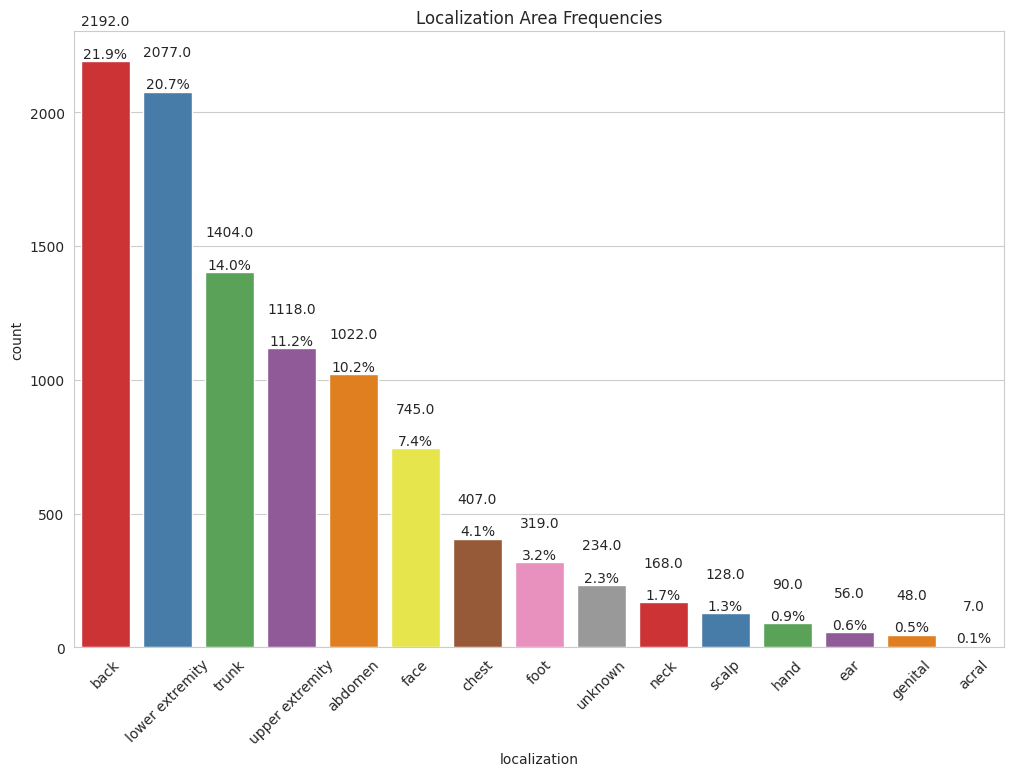

In [17]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
total = len(skin_df)
ax = sns.countplot(x='localization',data=skin_df, order = skin_df['localization'].value_counts().index, palette = 'Set1')
for container in ax.containers:
    labels = [f'{v.get_height()}\n\n{(v.get_height()/total)*100:.1f}%' for v in container]
    ax.bar_label(container, labels=labels)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

Se observa que la ubicación es mas frecuenta en la espalda, tren inferior, torso y tren superior, quizas pueda estar asociado el hecho de que:

* Son áreas frecuentemente expuestas al sol, lo que incrementa el riesgo de daño cutáneo y lesiones.

* Estas regiones ocupan más espacio en el cuerpo.

* Las personas no suelen revisar su espalda con frecuencia, lo que retrasa la detección y favorece la acumulación de lesiones visibles solo en exámenes médicos.

* Las extremidades están más expuestas a traumatismos, roce con ropa o superficies, lo que puede desencadenar o agravar ciertas lesiones.

# Relacion de ubicación con etiqueta de lesíon

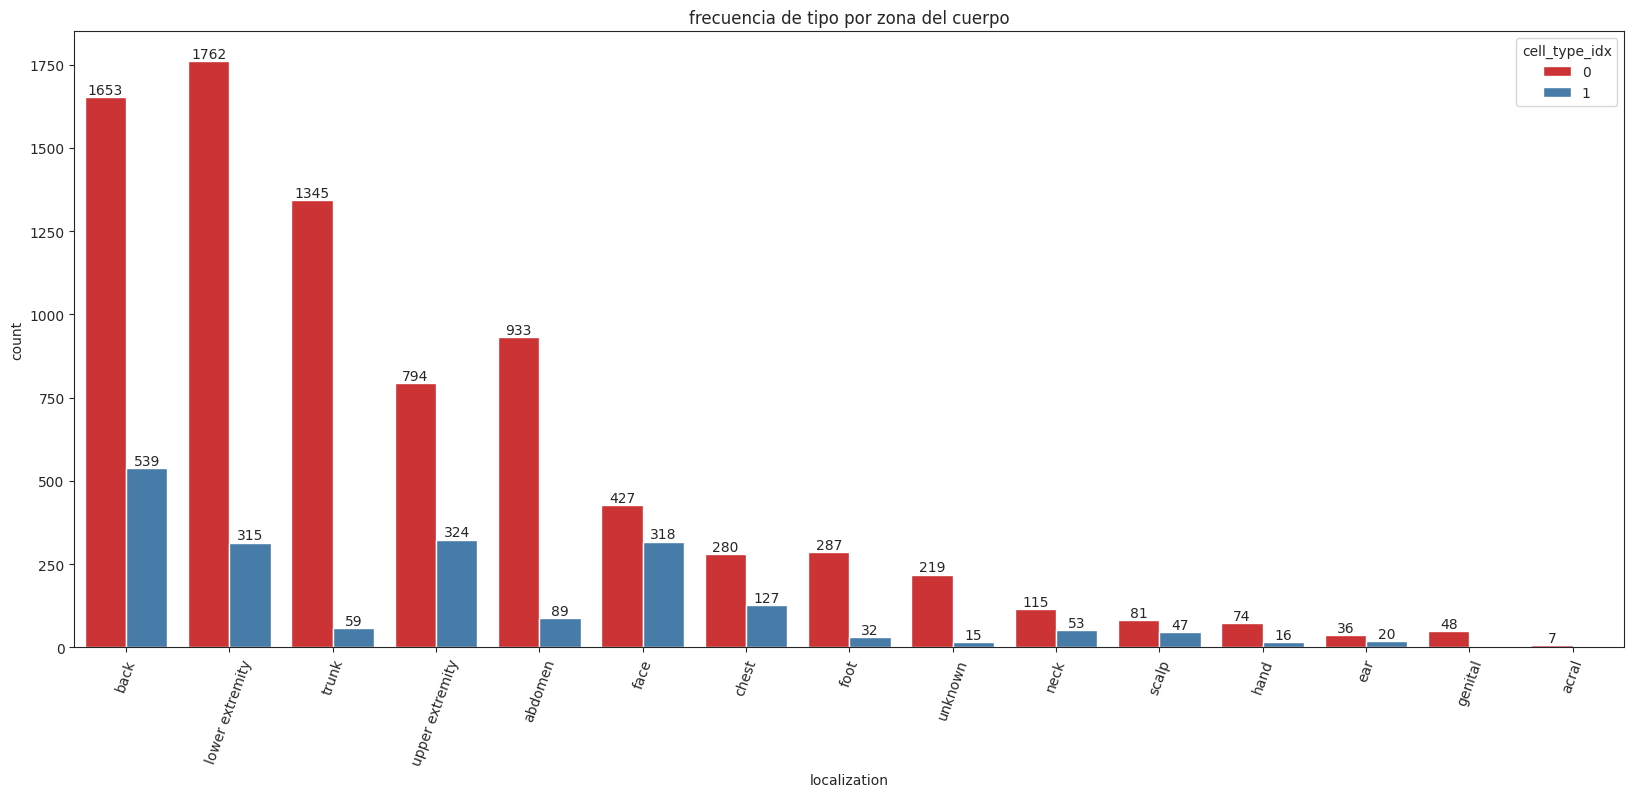

In [18]:
sns.set_style('ticks')
fig,axes = plt.subplots(figsize=(20,8))
ax = sns.countplot(x='localization',hue='cell_type_idx', data=skin_df, order = skin_df['localization'].value_counts().index, palette = 'Set1')
for container in ax.containers:
    ax.bar_label(container)
plt.title('frecuencia de tipo por zona del cuerpo')
plt.xticks(rotation=70)
plt.show()

Se observa que las lesiones presentadas en la cara tienen una probabilidad mayor de ser cancerosas en relacion a otras partes del cuerpo como; el tronco las extremidades inferioreso el abdomen, tambien es valido apreciar que el cuero cabelludo la oreja y el cuello son areas que tambien se encuentran afectadas por este tipo de lesiones (etiquetas)

<ipython-input-19-dab611d31fb2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='dx_type',data=skin_df, order = skin_df['dx_type'].value_counts().index, palette = 'Set1')


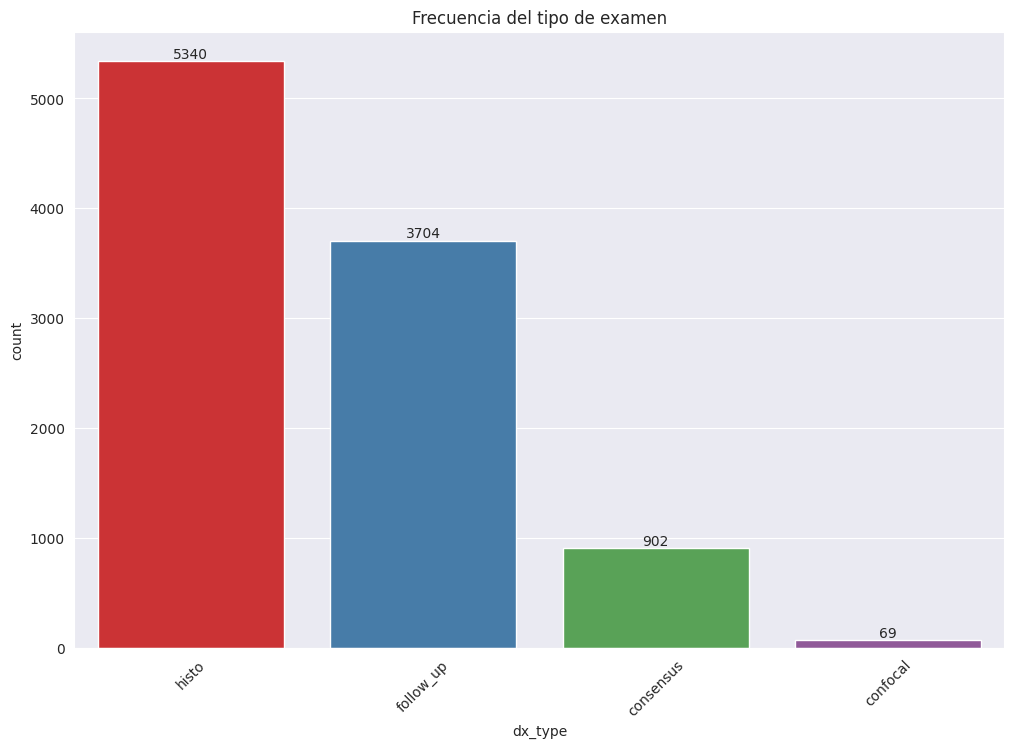

In [19]:
sns.set_style('darkgrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type',data=skin_df, order = skin_df['dx_type'].value_counts().index, palette = 'Set1')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Frecuencia del tipo de examen')
plt.xticks(rotation=45)
plt.show()

El uso del criterio diagnostico mas frecuente es por Histopatologia, considerado el mas precios de todos, posterior a este se encuentra el derivado de actividades de seguimiento

# Lesiones en edades.

In [20]:
skin_df.isnull().sum()


,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


In [21]:
# Reemplaza los valores nulos de la columna age del df por el valor promedio de esa columna
skin_df['age'] = skin_df['age'].fillna(skin_df['age'].mean())

In [22]:
skin_df.isnull().sum()


,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


In [23]:
import plotly.express as px

fig = px.histogram(
    skin_df,
    x="age",
    color="cell_type_idx",
    barmode="stack",
    title="Lesion (maligna vs benigna) segun la edad"
)
fig.show()

se puede observar que a medida que el paciente se hace mayor tiene mas probabilidad de padecer alguna lesion maligna acentuandose a partir de los 50 años de edad

In [24]:
print(skin_df.dtypes)


lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx      int64
dtype: object


Realizar exploración

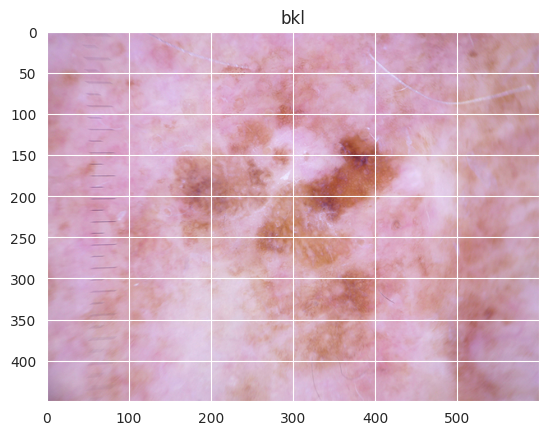

In [25]:
import cv2
import matplotlib.pyplot as plt

# Obtener la ruta de la imagen
ruta_imagen = skin_df.loc[skin_df['image_id'] == 'ISIC_0027419', 'path'].values[0]

# Leer la imagen con OpenCV (en BGR)
img_cv2 = cv2.imread(ruta_imagen)

# Convertir a RGB para mostrarla correctamente con matplotlib
img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

# Mostrarla
plt.imshow(img_rgb)
plt.title('bkl')
plt.show()

In [26]:
img_rgb.shape

(450, 600, 3)

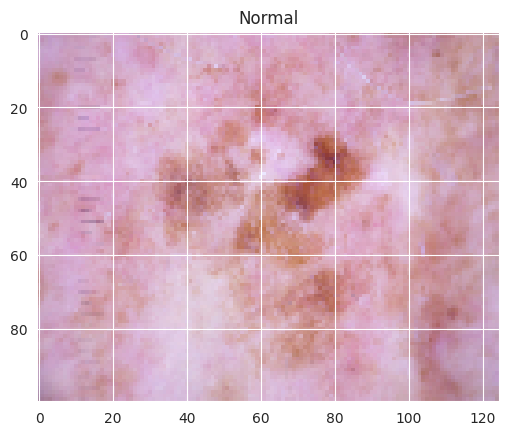

np.int64(37500)

In [27]:
img2_r = cv2.resize(img_rgb ,(125,100))
plt.imshow(img2_r)
plt.title('Normal')
plt.show()
np.prod(img2_r.shape)


Se va a redimensionar las imagenes 125 x 100 ya que esto nos ofrece una buena calidad al estar limitados de recursos.

en una consulta realizado a medicos, se establece que para tener una buen criterio de valoracion es necesario apreciar detalles tales como: bordes regulares, tonalidad, relieves (elevaciones, depresiones), descamasiones, vasos celulares alrededor. mostrandoles las imagenes de 100X75 y luego de 125X100, se definio que la segunda alternativa da mejores sensaciones, ya que la otra se ve algo pixelada

In [28]:
# Crear una nueva columna que contiene la imagen en forma de array redimensionada
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

In [29]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0027419.jpg,Benign keratosis-like lesions,0,"[[[189, 152, 194], [192, 156, 198], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025030.jpg,Benign keratosis-like lesions,0,"[[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0026769.jpg,Benign keratosis-like lesions,0,"[[[186, 127, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025661.jpg,Benign keratosis-like lesions,0,"[[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000_images/ISIC_0031633.jpg,Benign keratosis-like lesions,0,"[[[131, 88, 110], [142, 97, 120], [152, 107, 1..."


In [30]:
# Número de muestras por clase que se van a mostrar
n_samples = 5

# Se crea una figura con subplots de 7 filas, una por tipo de lesión 5 columnas
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))

# Se recorren simultáneamente los ejes de cada fila n_axs y los grupos del df según el cell_type
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):

    # Se coloca el nombre del tipo de lesión (cell_type) como título del primer gráfico de la fila
    n_axs[0].set_title(type_name)

    # Para cada eje (c_ax) y fila del grupo correspondiente (tipo de lesión), se seleccionan n_samples aleatorios
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off') # Se ocultan ejes

# Se guarda la figura generada como una imagen en disco
fig.savefig('category_samples.png', dpi=200)

Output hidden; open in https://colab.research.google.com to view.

In [31]:
# Se revisa la imagen para confirmar cada dimensión (alto, ancho, canales)

skin_df['image'].map(lambda x: x.shape).value_counts()


,count
image,
"(100, 125, 3)",10015


In [32]:
x=skin_df.drop(columns=['cell_type_idx'],axis=1)
y=skin_df['cell_type_idx']

In [33]:
#Para un Random Forest o XGBoost (imágenes + datos tabulares)
from sklearn.preprocessing import MinMaxScaler


# 1. Procesar variables tabulares
X_tab = skin_df[['age', 'sex', 'localization']].copy()

# Escalar 'age'
scaler = MinMaxScaler()
X_tab['age'] = scaler.fit_transform(X_tab[['age']])

# One-hot encoding para variables categóricas
X_tab = pd.get_dummies(X_tab, columns=['sex', 'localization'], drop_first=True)

# 2. Aplanar imágenes
X_img_flat = np.stack(skin_df['image'].values)            # (n, 100, 75, 3)
X_img_flat = X_img_flat.reshape(X_img_flat.shape[0], -1)  # (n, 22500)

# 3. Concatenar imagen y datos tabulares
X_rf = np.concatenate([X_img_flat, X_tab.values], axis=1)
y_rf = y.copy()

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.20,random_state=123)

In [35]:
# Imágenes en formato (n_samples, alto, ancho, canales)
X_cnn = np.stack(skin_df['image'].values)

# Etiquetas
y_cnn = skin_df['cell_type_idx'].values

In [36]:
##X_cnn = X_cnn / 255.0

In [37]:
##X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
   ## X_cnn, y_cnn, test_size=0.20, random_state=123, stratify=y_cnn
##)

In [38]:
import joblib

output_path = '/content/drive/MyDrive/cod/LEA3_health_7/salidas'
os.makedirs(output_path, exist_ok=True)

# Guardar archivos correctamente
joblib.dump(x_train, f"{output_path}/x_train.pkl")
joblib.dump(x_test, f"{output_path}/x_test.pkl")
joblib.dump(y_train, f"{output_path}/y_train.pkl")
joblib.dump(y_test, f"{output_path}/y_test.pkl")

##joblib.dump(X_train_cnn, f"{output_path}/X_train_cnn.pkl")
##joblib.dump(y_train_cnn, f"{output_path}/y_train_cnn.pkl")
##joblib.dump(X_test_cnn, f"{output_path}/X_test_cnn.pkl")
##joblib.dump(y_test_cnn, f"{output_path}/y_test_cnn.pkl")

['/content/drive/MyDrive/cod/LEA3_health_7/salidas/y_test.pkl']